In [92]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [93]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 16 data

In [94]:
data16 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester16data.csv")
data16.drop(['Dig_16_woodload', 'Dig_16_Liq_circ',
       'Digester_16_temperature', 'Digester_16_pressure',
       'Dig_16_phase_Comm Fail', 'Dig_16_phase_Configure',
       'Dig_16_phase_HP GAS RELEASE', 'Dig_16_phase_LIQUOR LOADING',
       'Dig_16_phase_LP GAS RELEASE', 'Dig_16_phase_PULP DISCHARGE',
       'Dig_16_phase_READY FOR LIQUOR',
       'Dig_16_phase_READY FOR PULP DISCH',
       'Dig_16_phase_READY FOR STEAMING', 'Dig_16_phase_READY FOR WOOD',
       'Dig_16_phase_SFACTOR TGT REACHED',
       'Dig_16_phase_SMOOTH STEAM FIXED',
       'Dig_16_phase_SMOOTH STEAM RAMP', 'Dig_16_phase_Scan Timeout',
       'Dig_16_phase_TEMP RAMP TO 110C', 'Dig_16_phase_TEMP RAMP TO 126C',
       'Dig_16_phase_TEMP RAMP TO TMAX', 'Dig_16_phase_VALVE CHECK',
       'Dig_16_phase_WOODLOAD COMPLETE', 'Dig_16_phase_WOODLOADING'], axis = 1, inplace=True)

create_ts_object(data16)

,Dig_16_HX
Timestamp,
2020-11-01 00:00:00,0.391519
2020-11-01 01:00:00,0.554788
2020-11-01 02:00:00,0.718056
2020-11-01 03:00:00,0.881325
2020-11-01 04:00:00,12.011068


### Stationarity

In [95]:
sts.adfuller(data16.Dig_16_HX)

(-8.375556727408808,
 2.592050665164384e-13,
 20,
 2188,
 {'1%': -3.4333422250634027,
  '5%': -2.8628618662999394,
  '10%': -2.567473694616472},
 10568.111862242506)

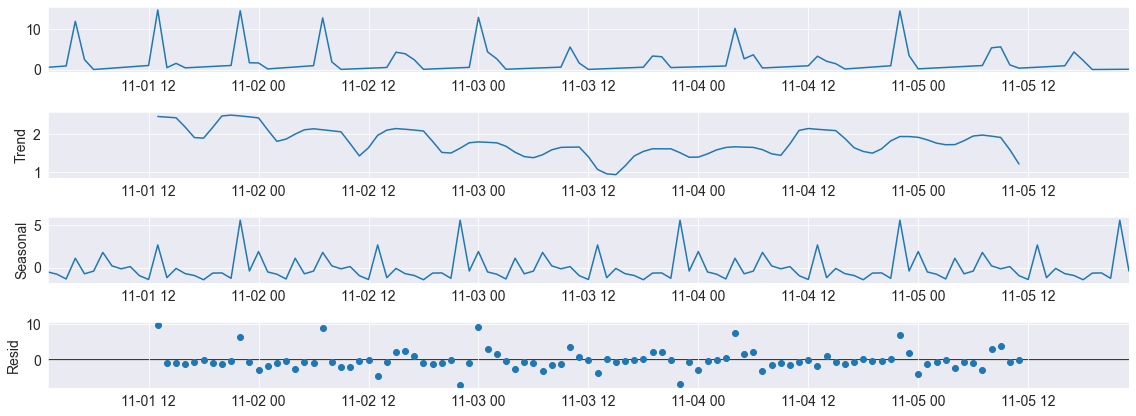

In [96]:
seas_dec = seasonal_decompose(data16[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

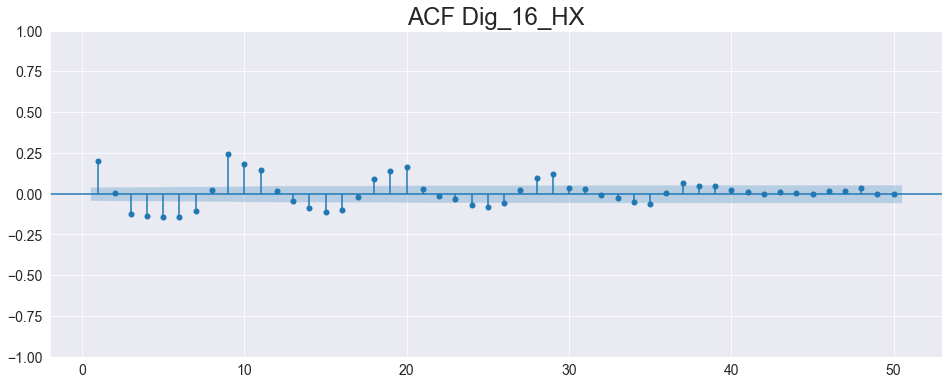

In [97]:
sgt.plot_acf(data16.Dig_16_HX, lags = 50, zero = False)
plt.title("ACF Dig_16_HX", size = 24)
plt.show()

### PACF

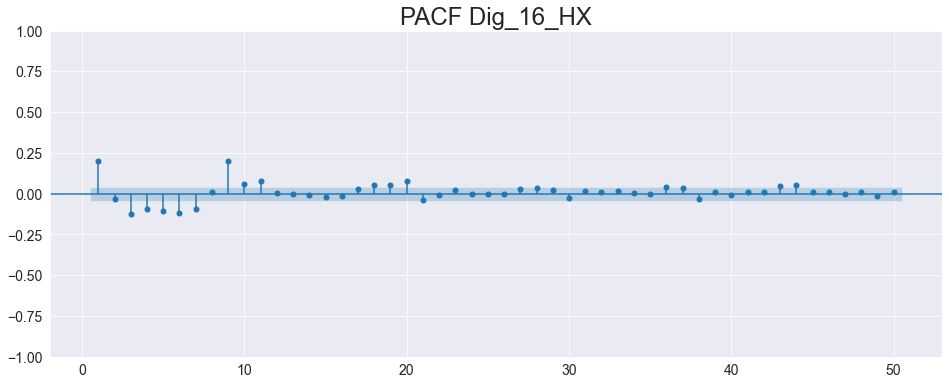

In [98]:
sgt.plot_pacf(data16.Dig_16_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_16_HX", size = 24)
plt.show()

In [99]:
#  Spare copy
data16_twin1 = data16.copy()

### Normalization

In [100]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [101]:
scaler = MinMaxScaler()
data16_twin = data16.copy()
scale_data(data16_twin, scaler)

,Dig_16_HX
Timestamp,
2020-11-01 00:00:00,0.026101
2020-11-01 01:00:00,0.036986
2020-11-01 02:00:00,0.047870
2020-11-01 03:00:00,0.058755
2020-11-01 04:00:00,0.800738


### Data Split

In [102]:
train_size = int(len(data16_twin)*0.85)
val_size = train_size + int(len(data16_twin)*0.10)
train_data16 = data16_twin.iloc[:train_size]
val_data16 = data16_twin.iloc[train_size:val_size]
test_data16 = data16_twin.iloc[val_size:]

In [103]:
val_data16.head()

,Dig_16_HX
Timestamp,
2021-01-18 05:00:00,0.035463
2021-01-18 06:00:00,0.028944
2021-01-18 07:00:00,0.022426
2021-01-18 08:00:00,0.015907
2021-01-18 09:00:00,0.009389


### Auto ARIMA Model

In [104]:
model_auto = auto_arima(train_data16.Dig_16_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\USER\AppData\Local\Programs\Python\Pyt

In [105]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 283.696
Date:                Sat, 12 Mar 2022   AIC                           -551.392
Time:                        12:31:52   BIC                           -507.097
Sample:                             0   HQIC                          -535.075
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.002     -0.071      0.943      -0.005       0.005
drift       9.729e-08   1.49e-06      0.065      0.948   -2.82e-06    3.01e-06
ar.L1         -0.6203      0.053    -11.642      0.000      -0.725      -0.516
ar.L2          0.4334      0.082      5.257      0.000       0.272       0.595
ar.L3          0.0594      0.044      1.355      0.175      -0.027       0.145
ma.L1          0.0446      0.051      0.867      0.386      -0.056       0.145
ma.L2         -0.8886      0.051    -17.376      0.000      -0.989      -0.788
sigma2         0.0461      0.002     25.328      0.000       0.043       0.050
===================================================================================
Ljung-Box (L1) (Q):                  28.19   Jarque-Bera (JB):              9591.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             2.89
Prob(H) (two-sided):                  0.64   Kurtosis:                        12.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [106]:
data16_resid_dataset = train_data16.copy()
data16_resid_dataset['residuals'] = model_auto.resid()

In [107]:
print(data16_resid_dataset.residuals.mean())
print(data16_resid_dataset.residuals.var())

0.0005575890056239899
0.043210403074865796


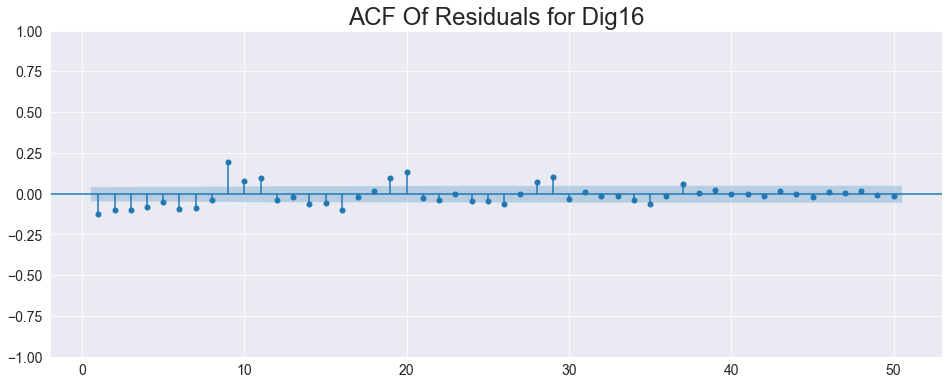

In [108]:
sgt.plot_acf(data16_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig16",size=24)
plt.show()

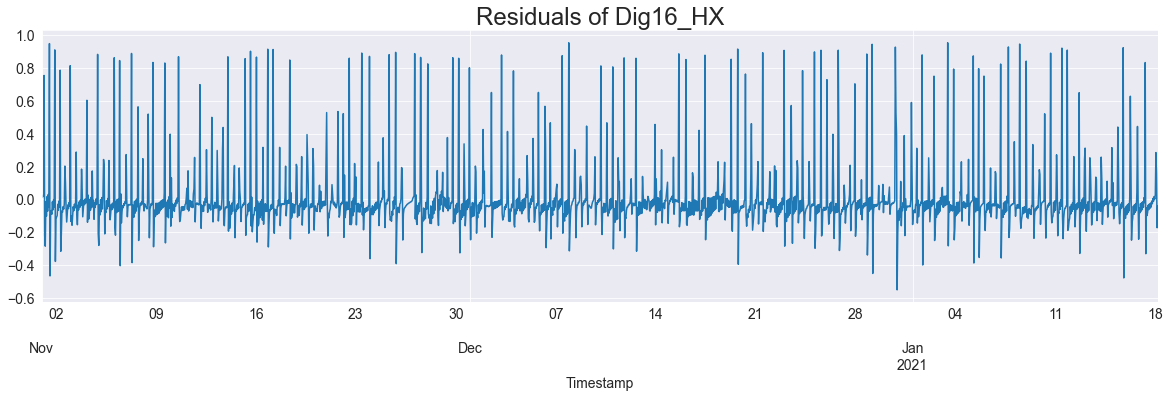

In [109]:
data16_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig16_HX",size=24)
plt.show()

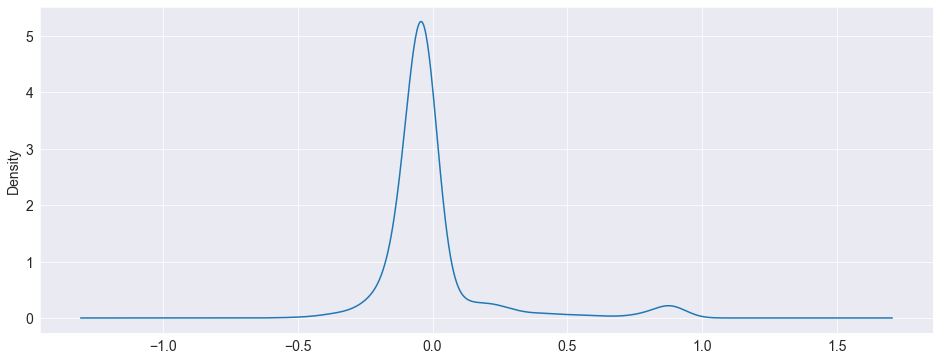

In [110]:
data16_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [111]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [112]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data16), index = val_data16.index))

In [113]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data16_twin1.Dig_16_HX.values.reshape(-1, 1))

array([[0.02610129],
       [0.03698585],
       [0.04787042],
       ...,
       [0.00250169],
       [0.01190778],
       [0.02131386]])

In [114]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

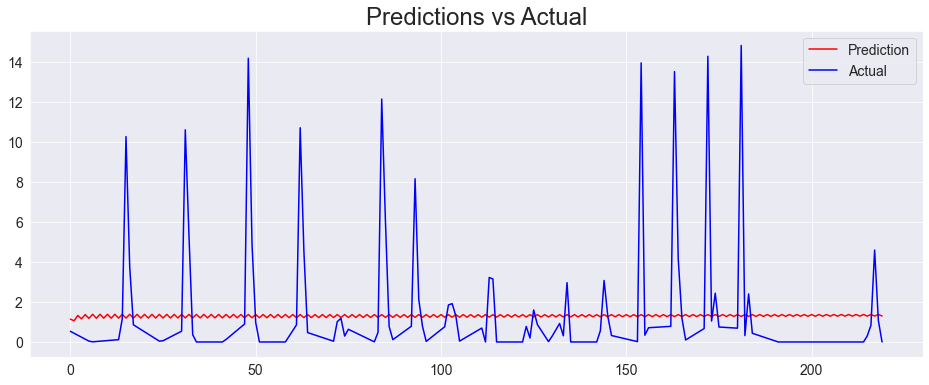

In [115]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data16_twin1.Dig_16_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [116]:
ndapred, ndaactual = df_pred, val_data16.Dig_16_HX.to_numpy()

In [117]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [118]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1021
RMSE: 0.1775


In [119]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig16pred.npy", df_pred2)

### Forecast

In [120]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data16), index = test_data16.index))

In [124]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

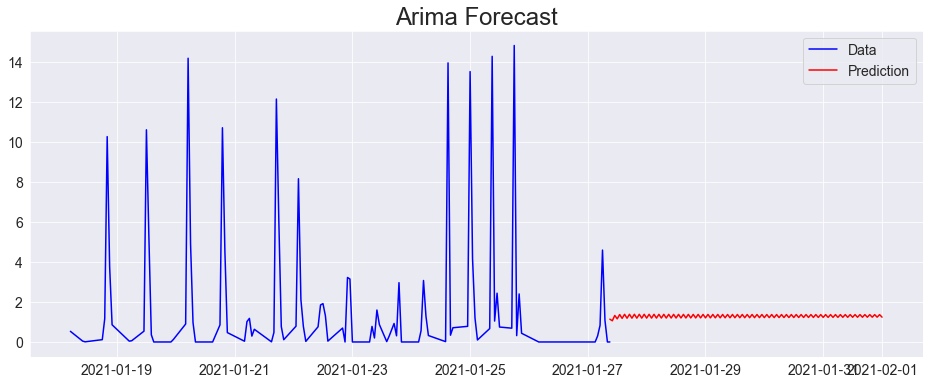

In [125]:
plt.plot(data16_twin1.index[1877:2098], data16_twin1.Dig_16_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data16.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [123]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig16fcast.npy", fcast)